In [3]:
import tensorflow.keras as kr
import transform_data as trans
import numpy as np

In [13]:
def predict_model(model, data_f, amount):
    def get_nextpos(coord, direct):
            next_pos = coord + [0, np.sin(direct[0] * np.pi / 180) * direct[1]]
            next_pos = next_pos + [np.cos(direct[0] * np.pi / 180) * direct[1], 0]
            return next_pos

    def trayectory(directions, initial_point):
        denormalized = directions * [360, 160] - [180, 0]
        # print(denormalized)
        li = []
        # print(denormalized[0])
        nexti = initial_point
        li.append(nexti)
        for i in range(len(denormalized)):
            nexti = get_nextpos(nexti, denormalized[i])
            # print(nexti)
            li.append(nexti.tolist())
        
        return np.array(li)

    data_asvec = trans.ev_tovec(data_f, show_graph=False, shrink_data=False)[1]
    print(data_asvec.shape)
    data_asvec_norm = np.true_divide((data_asvec.astype('float32') + [180, 0]), [360, 160])

    chunk = data_f.shape[0]

    li = []
    current = data_asvec_norm
    current_d = data_f
    trans.plot_events(current_d)
    for i in range(amount):
        prediction = model.predict(np.expand_dims(current, axis=0))
        datax_n = current_d[1]
        # trans.plot_events(datax[600][0:10])
        results = trayectory(prediction[0], datax_n)
        li.append(results[-1])

        current_d = np.concatenate((current_d[0:chunk+i+1], np.expand_dims(results[-1], axis=0)), axis=0)
        current_asvec = trans.ev_tovec(current_d, False, False)[1]
        current_asvec = np.true_divide((current_asvec.astype('float32') + [180, 0]), [360, 160])
        
        # print(current_asvec[1:], prediction[0][-1])
        current = np.concatenate((current_asvec, np.expand_dims(prediction[0][-1], axis=0)), axis=0)
        # print(current[-1])

    liarray = np.array(li)
    #############################################
    print(liarray.shape)
    liarray_asvec = trans.ev_tovec(liarray[1:], False, False)[1]
    # print(liarray_asvec)
    liarray_asvec = np.true_divide((liarray_asvec.astype('float32') + [180, 0]), [360, 160])

    # print(datax[event][chunk])

    return_v = trayectory(liarray_asvec, data_f[-1])
    print(data_f[-1])

    return return_v
    #################################################

Predicting...
(96, 2) [[188  26]
 [189  26]
 [190  26]
 [191  26]]
(95, 2)
(50, 2)
[234  64]
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Predicting...
(108, 2) [[369  30]
 [370  30]
 [371  30]
 [372  30]]
(107, 2)
(50, 2)
[421  60]
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Drawing
Predicting...
(56, 2) [[153 

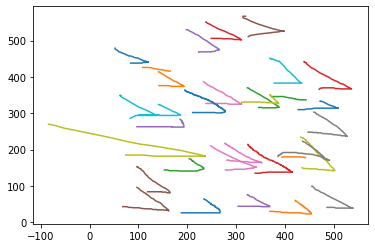

In [38]:
from tkinter import *
from tkinter.colorchooser import askcolor


class Paint(object):

    DEFAULT_PEN_SIZE = 5.0
    DEFAULT_COLOR = 'black'

    def __init__(self):
        self.root = Tk()

        # Variables
        self.data = [[]]
        self.event = []

        # Tensorflow
        self.model = kr.models.load_model('best_model1000.h5')

        self.pen_button = Button(self.root, text='pen', command=self.use_pen)
        self.pen_button.grid(row=0, column=0)

        self.brush_button = Button(self.root, text='brush', command=self.use_brush)
        self.brush_button.grid(row=0, column=1)

        self.color_button = Button(self.root, text='color', command=self.choose_color)
        self.color_button.grid(row=0, column=2)

        self.eraser_button = Button(self.root, text='eraser', command=self.use_eraser)
        self.eraser_button.grid(row=0, column=3)

        self.print_data = Button(self.root, text='data', command=self.save_data)
        self.print_data.grid(row=0, column=5)

        self.choose_size_button = Scale(self.root, from_=1, to=10, orient=HORIZONTAL)
        self.choose_size_button.grid(row=0, column=4)

        self.c = Canvas(self.root, bg='white', width=600, height=600)
        self.c.grid(row=1, columnspan=6)

        self.setup()
        self.root.mainloop()

    def setup(self):
        self.old_x = None
        self.old_y = None
        self.line_width = self.choose_size_button.get()
        self.color = self.DEFAULT_COLOR
        self.eraser_on = False
        self.active_button = self.pen_button
        self.c.bind('<Enter>', self.focus_on_enter)

        self.c.bind('s', self.predict)
        self.c.bind('<B1-Motion>', self.paint)
        self.c.bind('<ButtonRelease-1>', self.reset)

    def use_pen(self):
        self.activate_button(self.pen_button)

    def use_brush(self):
        self.activate_button(self.brush_button)

    def choose_color(self):
        self.eraser_on = False
        self.color = askcolor(color=self.color)[1]

    def use_eraser(self):
        self.activate_button(self.eraser_button, eraser_mode=True)

    def activate_button(self, some_button, eraser_mode=False):
        self.active_button.config(relief=RAISED)
        some_button.config(relief=SUNKEN)
        self.active_button = some_button
        self.eraser_on = eraser_mode

    def paint(self, event):
        self.line_width = self.choose_size_button.get()
        paint_color = 'white' if self.eraser_on else self.color
        if self.old_x and self.old_y:
            self.c.create_line(self.old_x, self.old_y, event.x, event.y,
                               width=self.line_width, fill=paint_color,
                               capstyle=ROUND, smooth=TRUE, splinesteps=36)
        self.old_x = event.x
        self.old_y = event.y
        
        self.event.append([self.old_x, self.old_y])

    def reset(self, event):
        self.old_x, self.old_y = None, None

    def save_data(self):
        self.data[0] = self.event
        self.event = []

        self.predict()
        

    def paint_this(self):
        import time
        for i in range(len(self.prediction)):
            print("Drawing")
            
            x = self.prediction[i][0]
            y = self.prediction[i][1]

            self.line_width = self.choose_size_button.get()
            paint_color = 'white' if self.eraser_on else self.color
            if self.old_x and self.old_y:
                self.c.create_line(self.old_x, self.old_y, x, y,
                                width=self.line_width, fill=paint_color,
                                capstyle=ROUND, smooth=TRUE, splinesteps=36)
            
            self.c.update_idletasks()

            time.sleep(0.1)
            self.old_x = x
            self.old_y = y

        self.old_x, self.old_y = None, None

    def focus_on_enter(self, event):
        self.c.focus_set()

    def predict(self):
        # Predict next position and write
        print("Predicting...")

        data_f = np.array(self.data[0])
        print(data_f.shape, data_f[0:4])

        self.prediction = predict_model(self.model, data_f, 50)

        self.color = 'orange'
        self.paint_this()
        self.color = self.DEFAULT_COLOR

program = Paint()

print("Paint finalizado")

